# Spaceship Titanic XGBOOST Model

## Imports

In [15]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Part 1: Read the Data

In [2]:
df = pd.read_csv("data/train.csv")

## Part 1-1: View the Data

In [3]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
# Quick summary of missing values and data types
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             2

## Part 2: Dropping Irrelevant Features and Eliminating missing values

In [5]:
# Drop irrelevant columns *only if they exist*
columns_to_drop = ['PassengerId', 'Name', 'Cabin']
existing_cols = [col for col in columns_to_drop if col in df.columns]
df.drop(existing_cols, axis=1, inplace=True)

# Fill missing boolean values (CryoSleep & VIP) with False, casting explicitly to boolean
df['CryoSleep'] = df['CryoSleep'].fillna(False).astype(bool)
df['VIP'] = df['VIP'].fillna(False).astype(bool)

# Fill Age with median
df['Age'] = df['Age'].fillna(df['Age'].median())

# Fill spending columns with 0 (assume they didn’t spend if missing)
for col in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
    df[col] = df[col].fillna(0)

# Fill missing categorical values with most common value (mode)
df['HomePlanet'] = df['HomePlanet'].fillna(df['HomePlanet'].mode()[0])
df['Destination'] = df['Destination'].fillna(df['Destination'].mode()[0])

C:\Users\Santiago\AppData\Local\Temp\ipykernel_16452\4257116467.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['CryoSleep'] = df['CryoSleep'].fillna(False).astype(bool)
C:\Users\Santiago\AppData\Local\Temp\ipykernel_16452\4257116467.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['VIP'] = df['VIP'].fillna(False).astype(bool)


In [6]:
# Check for any remaining missing values
print(df.isnull().sum())

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
dtype: int64


In [7]:
df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


## Part 3: Encoding our values

In [11]:
# Initialize LabelEncoder
le = LabelEncoder()

# Encode HomePlanet and Destination columns (Label Encoding)
df['HomePlanet'] = le.fit_transform(df['HomePlanet'])
df['Destination'] = le.fit_transform(df['Destination'])

# Encode CryoSleep and VIP columns (One-Hot Encoding, just using boolean values)
df['CryoSleep'] = df['CryoSleep'].astype(int)
df['VIP'] = df['VIP'].astype(int)

In [13]:
# Check the result of encoding
df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,False
1,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,True
2,1,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,False
3,1,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,False
4,0,0,2,16.0,0,303.0,70.0,151.0,565.0,2.0,True


## Part 4: Splitting the dataset

In [16]:
# Define features (X) and target (y)
X = df.drop('Transported', axis=1)  # All columns except 'Transported' are features
y = df['Transported']  # 'Transported' is the target variable

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=42)

# Check the shape of the resulting datasets
print(f'Training set size: {X_train.shape}')
print(f'Testing set size: {X_test.shape}')

Training set size: (6954, 10)
Testing set size: (1739, 10)


## Part 5: Train our XGBOOST Model

In [18]:
# Convert the data into DMatrix (XGBoost's internal format)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set parameters for XGBoost
params = {
    'objective': 'binary:logistic',  # For binary classification
    'eval_metric': 'logloss',        # Logarithmic loss for evaluation
    'max_depth': 6,                  # Maximum depth of trees
    'eta': 0.3,                      # Learning rate
    'subsample': 0.8,                # Fraction of data to use for each tree
    'colsample_bytree': 0.8          # Fraction of features to use for each tree
}


# Train the XGBoost model
num_round = 100  # Number of boosting rounds
bst = xgb.train(params, dtrain, num_round)

# Make predictions on the test set
y_pred = bst.predict(dtest)
y_pred = [1 if x > 0.5 else 0 for x in y_pred]  # Convert probabilities to 0 or 1

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.7746


## Part 6: Evaluate our Model

In [20]:
# Print classification report (precision, recall, F1-score)
print(classification_report(y_test, y_pred))

# Print confusion matrix
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.79      0.74      0.77       861
        True       0.76      0.81      0.78       878

    accuracy                           0.77      1739
   macro avg       0.78      0.77      0.77      1739
weighted avg       0.78      0.77      0.77      1739

[[640 221]
 [171 707]]


## Part 7: Hyperparameter Tuning via Gridsearch

In [23]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Set up the parameter grid
param_grid = {
    'max_depth': [3, 6, 9],
    'eta': [0.1, 0.3, 0.5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Create an XGBoost classifier
xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Set up GridSearchCV
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, verbose=2, n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)
print(f"Best Model Accuracy: {accuracy_score(y_test, y_pred_best):.4f}")


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best hyperparameters: {'colsample_bytree': 0.8, 'eta': 0.1, 'max_depth': 3, 'subsample': 0.7}
Best Model Accuracy: 0.7890


## Part 8: Plotting Features by Importance

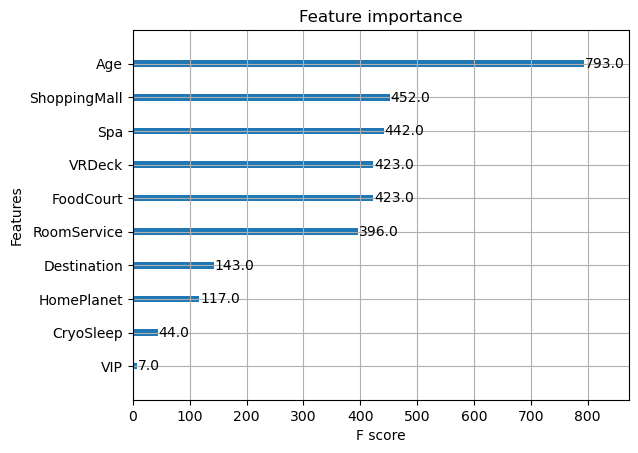

In [25]:
# Plot feature importance
xgb.plot_importance(bst)
plt.show()